# **Centrality dokumen**

## Instalasi paket dengan `pip`

Menginstal paket Python yang diperlukan untuk proyek

In [ ]:
!pip install Sastrawi pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.9 MB/s eta 0:00:00


## Import library dan download data NLTK

In [ ]:
import pandas as pd
import re

from tqdm import tqdm

import pickle
import nltk
import networkx as nx
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Membaca file csv kedalam dataframe

Membaca data yang telah di-crawl dan disimpan dalam file CSV ke dalam sebuah DataFrame pandas untuk analisis lebih lanjut

In [ ]:
file_path = '/content/drive/MyDrive/PPW/hasil_crawling.csv'
df = pd.read_csv(file_path)
df

,Judul,Kategori,Tanggal,Isi
0,Angkringan Pak Aam Pringgondani Jogja: Pernah ...,Kuliner,10 September 2024,"Umumnya, angkringan dianggap sebagai jujugan a..."
1,Cerita Penjual Some Jawa Pertama di Jogja: Set...,Kuliner,10 September 2024,Sudah 50 tahun Roso (77) menjual some Jawa ata...
2,Merasakan Kuliner Aceh yang Autentik dan Merak...,Kuliner,7 September 2024,Warkop Aceh Bang Zainal yang terletak di pingg...
3,Kerja di Pasar Minggu Jakarta Selatan Bikin Ta...,Kuliner,4 September 2024,"Kerja di Pasar Minggu, Jakarta Selatan, sebena..."
4,Warung Makan Barokah Sih Surabaya: Rp8 Ribu Su...,Kuliner,23 Agustus 2024,Di antara semakin banyaknya warung makan yang ...
...,...,...,...,...
95,Buang Biaya Kuliah IPB Rp30 Juta Demi Pindah k...,Kampus,24 Juni 2024,"Sudah diterima kuliah di IPB, kampus cukup fav..."
96,Mahasiswa Asal Surabaya Nekat Kuliah HI UB Mal...,Kampus,22 Juni 2024,"Demi memenuhi keinginan orang tua, mahasiswa a..."
97,"Penyesalan Tolak IPB Demi Masuk ITS Surabaya, ...",Kampus,22 Juni 2024,"Awalnya bermimpi masuk IPB, begitu diterima, a..."
98,Mahasiswa PTN Surabaya Lulus Sarjana di Semest...,Kampus,21 Juni 2024,"Menjelang batas waktu drop out (DO), mahasiswa..."


## Preprosesing teks

Mengubah teks menjadi huruf kecil, membersihkan tanda baca dan angka, normalisasi spasi, pembersihan stopwords setelah tokenisasi, stemming dengan sastrawi

In [ ]:
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

df['lower case'] = df['Isi'].apply(clean_lower)

casefolding = pd.DataFrame(df['lower case'])

def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z ]')
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

df['tanda baca'] = df['lower case'].apply(clean_punct)

def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

df['spasi'] = df['tanda baca'].apply(_normalize_whitespace)

def clean_stopwords(text):
    if isinstance(text, str):
        stopword = set(stopwords.words('indonesian'))
        text = ' '.join(word for word in text.split() if word not in stopword)
        return text.strip()
    return text

df['stopwords'] = df['spasi'].apply(clean_stopwords)

def sastrawistemmer(text):
    factory = StemmerFactory()
    st = factory.create_stemmer()
    text = ' '.join(st.stem(word) for word in tqdm(text.split()) if word in text)
    return text

df['stemming'] = df['stopwords'].apply(sastrawistemmer)

100%|██████████| 569/569 [00:13<00:00, 42.35it/s]


## Vektorisasi dengan countvectorizer

Mengubah teks yang telah diproses menjadi representasi numerik berdasarkan frekuensi kata menggunakan `CountVectorizer`.

In [ ]:
count_vectorizer = CountVectorizer()

if 'stemming' in df.columns:
    corpus = df['stemming'].dropna().tolist()
else:
    raise KeyError("Kolom 'stemming' tidak ada di DataFrame")

x_count = count_vectorizer.fit_transform(corpus)
feature_names = count_vectorizer.get_feature_names_out()
x_count_df = pd.DataFrame(x_count.toarray(), columns=feature_names)

x_count_df

,aam,aanisah,abadi,abai,abang,abangan,abar,abd,abdi,abdul,...,yura,yusuf,zainal,zaman,zias,zonk,zoom,zuhur,zumiatun,zunnur
0,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,24,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vektorisasi dengan TfidfVectorizer

Mengubah teks yang telah diproses menjadi representasi numerik menggunakan `TfidfVectorizer`, yang mempertimbangkan frekuensi kata serta pentingnya kata dalam dokumen.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
corpus = df['stemming'].tolist()
x_tfidf = tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(x_tfidf.toarray(), columns=feature_names)
cat_df = df["Kategori"]
tfidf_df['Kategori'] = cat_df.values
tfidf_df = tfidf_df[['Kategori'] + [col for col in tfidf_df.columns if col != 'Kategori']]

tfidf_df

,Kategori,aam,aanisah,abadi,abai,abang,abangan,abar,abd,abdi,...,yura,yusuf,zainal,zaman,zias,zonk,zoom,zuhur,zumiatun,zunnur
0,Kuliner,0.534378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Kuliner,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Kuliner,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.561223,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Kuliner,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Kuliner,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Kampus,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
96,Kampus,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.046536,0.0,0.0,0.0,0.0
97,Kampus,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
98,Kampus,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Menghitung consine similarity

Menghitung kesamaan kosinus antar dokumen berdasarkan representasi TF-IDF mereka, yang kemudian digunakan untuk membangun matriks adjacency (kedekatan) antar dokumen.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_values = tfidf_df.drop(columns=['Kategori'])
adjacency_matrix = cosine_similarity(tfidf_values)

## Membuat dataframe matriks Adjacency

Mengubah matriks adjacency (kesamaan kosinus) menjadi sebuah DataFrame pandas untuk memudahkan analisis dan visualisasi.

In [ ]:
adjacency_df = pd.DataFrame(adjacency_matrix)
adjacency_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.029167,0.028933,0.021228,0.050742,0.015899,0.019530,0.059171,0.037285,0.032226,...,0.014060,0.022917,0.055103,0.043563,0.016490,0.012786,0.015893,0.021288,0.049769,0.021441
1,0.029167,1.000000,0.032636,0.094720,0.038400,0.039438,0.034809,0.031915,0.035517,0.047772,...,0.025049,0.032022,0.029946,0.019996,0.013673,0.009627,0.027056,0.013357,0.032630,0.027628
2,0.028933,0.032636,1.000000,0.037788,0.075536,0.030049,0.034186,0.055560,0.076991,0.070150,...,0.018722,0.034579,0.039674,0.028277,0.018098,0.018644,0.017567,0.019824,0.037630,0.024826
3,0.021228,0.094720,0.037788,1.000000,0.083410,0.091166,0.036977,0.034426,0.041154,0.046590,...,0.024925,0.151677,0.029056,0.014697,0.027749,0.014367,0.022877,0.029840,0.018092,0.020300
4,0.050742,0.038400,0.075536,0.083410,1.000000,0.184827,0.027911,0.123959,0.178949,0.099368,...,0.025247,0.038614,0.051411,0.054293,0.026217,0.030485,0.035285,0.019631,0.073976,0.031410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.012786,0.009627,0.018644,0.014367,0.030485,0.010667,0.030923,0.041239,0.031315,0.022048,...,0.152857,0.064964,0.046280,0.039707,0.054628,1.000000,0.148417,0.408994,0.144832,0.052466
96,0.015893,0.027056,0.017567,0.022877,0.035285,0.009838,0.024136,0.041992,0.018177,0.020011,...,0.131659,0.065862,0.056433,0.042039,0.045340,0.148417,1.000000,0.099580,0.131234,0.039553
97,0.021288,0.013357,0.019824,0.029840,0.019631,0.010019,0.020148,0.038502,0.020446,0.023054,...,0.103058,0.033611,0.030057,0.025498,0.035074,0.408994,0.099580,1.000000,0.079898,0.035907
98,0.049769,0.032630,0.037630,0.018092,0.073976,0.025665,0.072771,0.080596,0.063872,0.038952,...,0.112906,0.074117,0.094094,0.079897,0.047106,0.144832,0.131234,0.079898,1.000000,0.064552


## Membangun graf jaringan dengan NetworkX

Membangun dan memvisualisasikan graf jaringan berdasarkan kesamaan kosinus antar dokumen. Node mewakili dokumen, dan edge mengindikasikan tingkat kesamaan yang melebihi ambang batas tertentu.

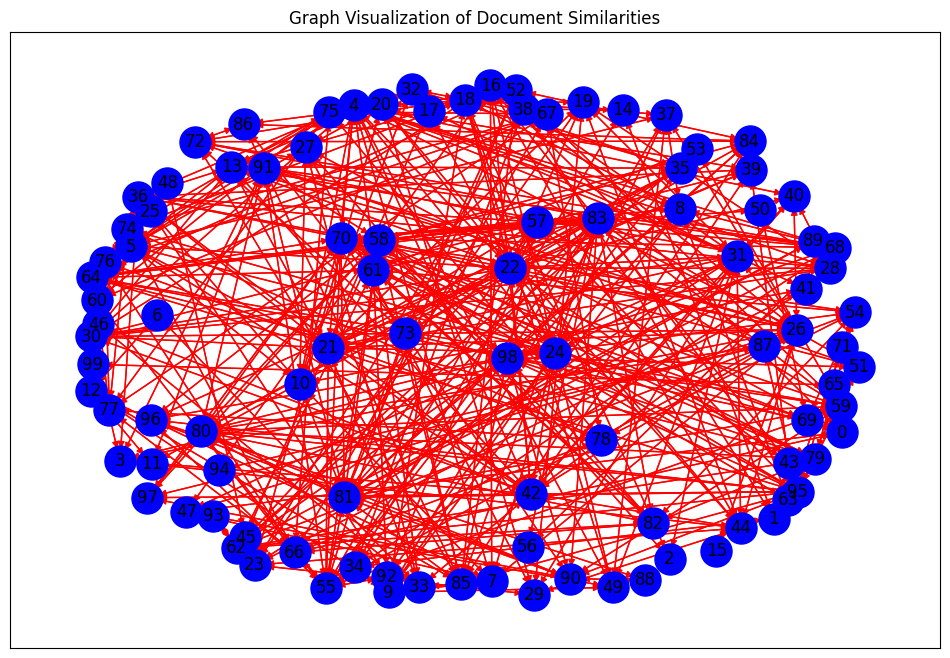

In [ ]:
G_preprocessing = nx.DiGraph()

# Add nodes to the graph
for i in range(len(adjacency_matrix)):
    G_preprocessing.add_node(i)

# Add edges based on cosine similarity threshold of 0.1
for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix)):
        similarity_preprocessing = adjacency_matrix[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

# Generate layout for visualization
pos = nx.spring_layout(G_preprocessing, k=2)

# Draw the nodes, edges, and labels
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

# Show plot
plt.title("Graph Visualization of Document Similarities")
plt.show()


## Menghitung Closeness dan Betweenness Centrality

Menghitung dan menganalisis dua ukuran centrality (closeness dan betweenness) pada graf jaringan untuk mengidentifikasi dokumen-dokumen yang paling penting atau strategis dalam jaringan.

In [ ]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G_preprocessing)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_preprocessing, normalized=True)

# Combine the centrality measures into a DataFrame for easy comparison
centrality_df = pd.DataFrame({
    'Closeness Centrality': closeness_centrality,
    'Betweenness Centrality': betweenness_centrality
})

# Display the top 5 documents with the highest centrality values
centrality_df.sort_values(by=['Closeness Centrality', 'Betweenness Centrality'], ascending=False)


,Closeness Centrality,Betweenness Centrality
83,0.464789,0.123663
24,0.460465,0.128881
55,0.460465,0.096704
21,0.456221,0.087416
70,0.452055,0.098839
...,...,...
1,0.244444,0.000000
14,0.244444,0.000000
94,0.233491,0.000000
99,0.207113,0.000000
